In [336]:
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import cv2
import os
from torchvision import transforms
from torch.utils.data import random_split
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [320]:
DATA_DIR = 'Dataset/'
DATA_CSV_FILE = 'label.csv'
MODEL_PATH = 'checkpoint/model.pt'

In [321]:
data_df = pd.read_csv(DATA_CSV_FILE,dtype=str)
data_df.head()

,path,label
0,1.png,6968
1,2.png,8853
2,3.png,9137
3,4.png,1135
4,5.png,9647


In [322]:
class myDataset(Dataset):
    def __init__(self, annotations_file, img_dir,transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, dtype=str)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.img_labels)
    def str2list(self,label):
        label_list = list(map(int,label))
        return label_list
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = cv2.imread(img_path,cv2.IMREAD_COLOR)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
            label = self.str2list(label)
            label = torch.tensor(label)
        return image, label

In [323]:
def preprocessing(image):
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    median_img = cv2.medianBlur(hsv_img, ksize=3)
    laplacian_img = cv2.Laplacian(median_img, -1, ksize=3)
    s = laplacian_img[:,:,1]
    h = laplacian_img[:,:,0]
    final_mask = cv2.bitwise_or(h, s)                                   
    return final_mask


In [324]:
transform = transforms.Compose([
    transforms.Lambda(preprocessing),
    transforms.ToTensor(),
])



In [325]:
dataset = myDataset(DATA_CSV_FILE, DATA_DIR ,transform=transform  ) 
print(f'Number of dataset: {len(dataset)}')
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True )
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False )
print(f'Number of train_dataset: {len(train_dataloader)}')
print(f'Number of valid_dataset: {len(valid_dataloader)}')


Number of dataset: 1000
Number of train_dataset: 13
Number of valid_dataset: 4


Text(0.5, 1.0, 'tensor([5, 5, 6, 5])')

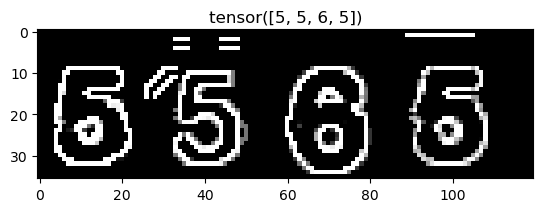

In [326]:
image, label = train_dataset[0]
image=image.permute(1, 2, 0)
plt.imshow(image,cmap='gray')
plt.title(label)



In [327]:
class CRNN(nn.Module):
    def __init__(self,numChannels=1 ,class_num =11):
        super(CRNN,self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=numChannels ,out_channels=64 ,kernel_size=(3,3),stride=1,padding=1),
            nn.MaxPool2d(kernel_size=(2,2),stride=2),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),stride=1,padding=1),
            nn.MaxPool2d(kernel_size=(2,2),stride=2),
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3),stride=1,padding=1),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=(3,3),stride=1,padding=1),
            nn.MaxPool2d(kernel_size=(2, 1),stride=(2,1))  ,
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=(3,3),stride=1,padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=(3,3),stride=1,padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.MaxPool2d(kernel_size=(2, 1),stride=(2,1))  ,
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=(2,1)),
        )
        self.lstm = nn.LSTM(512 ,256, 2, batch_first=True, bidirectional=True)
        self.fc_layer = nn.Linear(in_features=512,out_features=class_num)

    def map2seq(self,input_tensor):
        seq_tensor = input_tensor.squeeze(dim=2)
        seq_tensor = seq_tensor.permute(0,2,1)
        return seq_tensor
    def seq2label(self,seq_tensor):
        lstm_output, (_, _) = self.lstm(seq_tensor)
        batch_size ,seq_len ,hidden_unit = lstm_output.shape
        flattened_output = lstm_output.reshape(-1,hidden_unit)
        logits = self.fc_layer(flattened_output)
        logits = logits.reshape(batch_size, seq_len, -1)
        logits = logits.permute(1,0,2)
        log_probs = logits.log_softmax(2)
        return log_probs
    def forward(self,x):
        x = self.feature_extractor(x)
        seq_tensor = self.map2seq(x)    
        log_probs = self.seq2label(seq_tensor)
        return log_probs 




In [328]:
data_iter = iter(train_dataloader)

image, label = next(data_iter)
crnn_model = CRNN()
predicted_classes = crnn_model(image)
print("CRNN Output shape:", predicted_classes.shape)


CRNN Output shape: torch.Size([30, 64, 11])


In [329]:
CHARS = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9','-']
model = CRNN()
ctc_loss = nn.CTCLoss(blank=len(CHARS)-1, reduction='mean',zero_infinity=True)
lr =1e-3
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
train_epoch = 100

In [330]:
def decode(raw_predicted_labels):
    predicted_label = [label for i, label in enumerate(raw_predicted_labels)
                       if label != len(CHARS)-1 and (i == 0 or label != raw_predicted_labels[i-1])]
    return predicted_label


In [331]:
train_accuracy_list=[]
valid_accuracy_list=[]
train_loss_list = []
valid_loss_list = []

def train_model(train_epoch, model, train_dataloader, valid_dataloader, ctc_loss, optimizer, log_interval=5):
    total_train_step = 0
    best_accuracy =0.0
    model.train()

    for epoch in range(train_epoch):
        print("---- the {} epoch of training---".format(epoch))
        total_train_samples = 0
        total_train_accuracy = 0
        # Training phase
        for data in train_dataloader:
            predicted_label = []
            image, label = data
            log_probs = model(image)
            batch_size = log_probs.size(1)

            raw_predicted_labels = torch.argmax(log_probs, dim=2)
            accuracy_counter = 0

            for i in range(batch_size):
                predicted_label = decode([x.item() for x in raw_predicted_labels[:, i]])
                target_label = [x.item() for x in label[i, :]]
                if predicted_label == target_label:
                    accuracy_counter += 1
                total_train_samples += batch_size
                total_train_accuracy += accuracy_counter

            targets = label.view(-1)
            input_lengths = torch.tensor([log_probs.size(0)] * batch_size, dtype=torch.long)
            target_lengths = torch.tensor([label.size(1)] * batch_size, dtype=torch.long)
            train_loss = ctc_loss(log_probs, targets, input_lengths, target_lengths)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            total_train_step += 1

        train_accuracy = total_train_accuracy / total_train_samples
        train_accuracy_list.append(train_accuracy)
        train_loss_list.append(train_loss)
        print("Epoch {}, Train Loss: {:.4f}, Train Accuracy: {:.4f}".format(epoch, train_loss, train_accuracy))

        model.eval()
        total_valid_samples = 0
        total_valid_accuracy = 0

        with torch.no_grad():
            for data in valid_dataloader:
                image, label = data
                log_probs = model(image)
                batch_size = log_probs.size(1)

                raw_predicted_labels = torch.argmax(log_probs, dim=2)
                accuracy_counter = 0

                for i in range(batch_size):
                    predicted_label = decode([x.item() for x in raw_predicted_labels[:, i]])
                    target_label = [x.item() for x in label[i, :]]
                    if predicted_label == target_label:
                        accuracy_counter += 1

                targets = label.view(-1)
                input_lengths = torch.tensor([log_probs.size(0)] * batch_size, dtype=torch.long)
                target_lengths = torch.tensor([label.size(1)] * batch_size, dtype=torch.long)
                valid_loss = ctc_loss(log_probs, targets, input_lengths, target_lengths)

                total_valid_samples += batch_size
                total_valid_accuracy += accuracy_counter

        model.train()  # Switch back to training mode

        valid_accuracy = total_valid_accuracy / total_valid_samples
        valid_accuracy_list.append(valid_accuracy)
        valid_loss_list.append(valid_loss)
        print("Valid Loss: {:.4f},Validation Accuracy: {:.4f}".format(valid_loss,valid_accuracy))
        if valid_accuracy > best_accuracy:
            torch.save(model.state_dict(), 'best-model-parameters.pt')
            print("best model saved Accuracy {:.4f} => {:.4f}".format(best_accuracy,valid_accuracy))
            best_accuracy = valid_accuracy

    print("Training finished.")

train_model(train_epoch,model,train_dataloader,valid_dataloader,ctc_loss,optimizer)

---- the 0 epoch of training---


Epoch 0, Train Loss: 2.7450, Train Accuracy: 0.0000
Valid Loss: 2.6937,Validation Accuracy: 0.0000
---- the 1 epoch of training---
Epoch 1, Train Loss: 2.7243, Train Accuracy: 0.0000
Valid Loss: 2.7232,Validation Accuracy: 0.0000
---- the 2 epoch of training---
Epoch 2, Train Loss: 2.6941, Train Accuracy: 0.0000
Valid Loss: 2.6980,Validation Accuracy: 0.0000
---- the 3 epoch of training---
Epoch 3, Train Loss: 2.6951, Train Accuracy: 0.0000
Valid Loss: 2.6883,Validation Accuracy: 0.0000
---- the 4 epoch of training---
Epoch 4, Train Loss: 2.6889, Train Accuracy: 0.0000
Valid Loss: 2.6891,Validation Accuracy: 0.0000
---- the 5 epoch of training---
Epoch 5, Train Loss: 2.6883, Train Accuracy: 0.0000
Valid Loss: 2.6954,Validation Accuracy: 0.0000
---- the 6 epoch of training---
Epoch 6, Train Loss: 2.6854, Train Accuracy: 0.0000
Valid Loss: 2.6907,Validation Accuracy: 0.0000
---- the 7 epoch of training---
Epoch 7, Train Loss: 2.6635, Train Accuracy: 0.0000
Valid Loss: 2.6260,Validation A

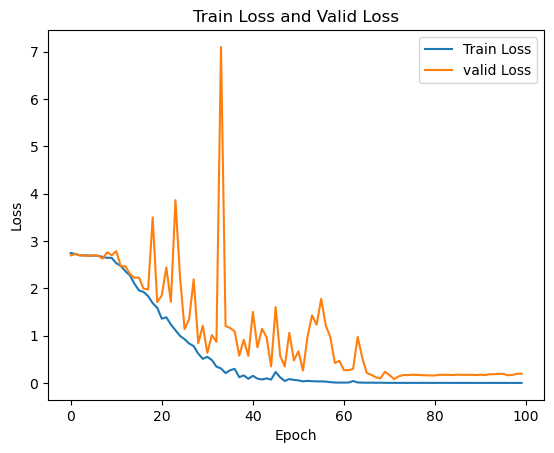

In [352]:
plt.plot(train_loss_list,label='Train Loss')
plt.plot(valid_loss_list,label="valid Loss")
plt.title("Train Loss and Valid Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

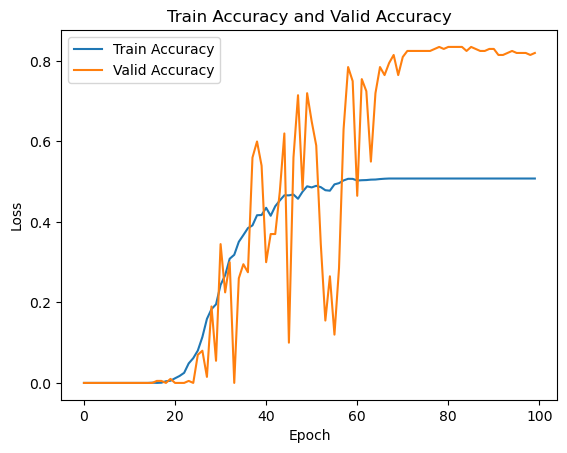

In [353]:
plt.plot(train_accuracy_list,label='Train Accuracy')
plt.plot(valid_accuracy_list,label="Valid Accuracy")
plt.title("Train Accuracy and Valid Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
def test(state_dict_path):
    model = CRNN()
    best_model = torch.load(state_dict_path)
    model.load_state_dict(best_model)
    model.eval()
    image, label = valid_dataset[2]
    image = image.unsqueeze(0)
    print("Label         :",label.tolist())
    log_probs = model(image)
    raw_predicted_labels = torch.argmax(log_probs, dim=2).squeeze(1)
    raw_predicted_labels = [x.item()for x in raw_predicted_labels]
    predicted_label =decode(raw_predicted_labels)
    print("Predict Label :",predicted_label)
    model.train()

state_dict_path = 'best-model-parameters.pt'
test(state_dict_path)
